### Finite Volume Flow ###

Solving fluid dynamic equations using the finite volume method. 

The easiest to implement set of finite volumes is a rectangular grid. We will investigate flow using a $n_{x} \times n_{y}$ grid. At each point we will calculate the pressure inside the grid $P_{i,j}$, and the velocity of the fluid through its various faces $u_{i,j}$, $u_{i-1,j}$, $v_{i,j}$, $v_{i,j-1}$. Note that the velocity of the fluid through the right-side face of the volume $u_{i,j}$ is equal and opposite to the velocity entering the left-side face of the adjacent volume on the right. 

In [40]:
#Basics
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

Initialize the grid

In [41]:
#Simulation properties
Lx = 2.5
Ly = 2.0
##################################################
#Set up rectangular obstacles  x_0, x_f, y_0, y_f
##################################################
obstarr = np.array([[0.8,1.0,0.84,0.94],[0.8,1.0,1.06,1.16]]) #two rectangles
##################################################
nx = 300
ny = 200
dx = Lx / nx
dy = Ly / ny
nt = 1000        # Number of time steps  ; increae to 1000 for Re <= 20 ; decrease to 750 for Re > 20
dt = 1.5E-4     # time step
u_init = 4.00      # Initial velocity
rho = 0.1        # Density
Re = 60        # No higher than 60, no lower than 5

dt ok < 1.302e-03


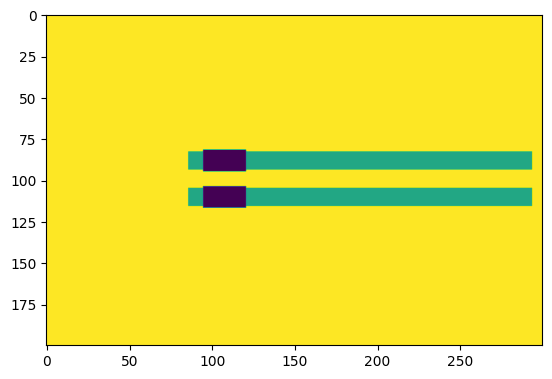

In [42]:
###########################
# Initialization
###########################
#
#######
# Create obstacle index array
#######
obstijarr = np.zeros(shape=obstarr.shape, dtype=int)
for i in range(obstarr.shape[0]):
    obstijarr[i] = np.append(obstarr[i,0:2]/dx,obstarr[i,2:]/dy).astype(int)
#######
p_init = 0.5*rho*u_init**2
p = np.ones((nx, ny)) * p_init * 0.25
v = np.zeros((nx, ny))
u = np.ones((nx, ny))*u_init     #This sets a uniform initial velocity to the right
mu = rho*u_init*(obstarr[0,1]-obstarr[0,0])/Re #calculates mu from Re and velocity
##########
#check dt
##########
if (dt > .25*rho*dx**2/mu):
    print("Warning: dt too large; dt < {0:1.3e}".format(.25*rho*dx**2/mu))
    dt = .1*rho*dx**2/mu
    print("dt now = {0:1.3e}".format(dt))
else:
    print("dt ok < {0:1.3e}".format(.25*rho*dx**2/mu))

u[:,0] = u_init
for i in range(obstijarr.shape[0]):
    u[obstijarr[i,0]-10:-6,obstijarr[i,2]-1:obstijarr[i,3]+1] = 0.6*u_init #slower in front and behind obstacle
    u[obstijarr[i,0]-1:obstijarr[i,1]+1,obstijarr[i,2]-2:obstijarr[i,3]+2] = 0 #no slip condition
    p[obstijarr[i,0]-1:obstijarr[i,0]+1,obstijarr[i,2]-1:obstijarr[i,3]+1] = p_init #slight increase init p at front

plt.imshow(u.T)

In [43]:
##### Pressure Correction

def pressure(p,u,v,rho,mu,dt,dx,dy,obstijarr):
    nx, ny = p.shape
    b = np.zeros((nx, ny))
    b[1:-1, 1:-1] = (1 / dt) * ((u[2:,1:-1] - u[0:-2,1:-1]) / (2 * dx) + (v[1:-1,2:] - v[1:-1,0:-2]) / (2 * dy)) -\
                    ((u[2:,1:-1] - u[0:-2,1:-1]) / (2 * dx))**2 - 2 * ((u[1:-1,2:] - u[1:-1,0:-2]) / (2 * dy) *
                    (v[2:,1:-1] - v[0:-2,1:-1]) / (2 * dx))- ((v[1:-1,2:] - v[1:-1,0:-2]) / (2 * dy))**2    
    for q in range(45):
        pn = p.copy()
 
        p[1:-1, 1:-1] = (((pn[2:,1:-1] + pn[0:-2,1:-1]) * dy**2 + (pn[1:-1,2:] + pn[1:-1,0:-2]) * dx**2) / (2 * (dx**2 + dy**2)) -
                    (rho * dx**2 * dy**2) / (2 * (dx**2 + dy**2)) * b[1:-1,1:-1])
        #Left/right boundary conditions
        p[0,1:-1] = p[1,1:-1] - (p[2,1:-1] - p[1,1:-1]) #simplke linear extroploation
        p[-1,1:-1] = (p[-2,1:-1] - p[-3,1:-1]) + p[-2,1:-1] 
        #Top/Bottom
        p[:,-1] = p[:,-2]
        p[:,0] = p[:,1]
        #Boundary conditions for obstacle
        for n in range(obstijarr.shape[0]):    
            p[obstijarr[n,0],obstijarr[n,2]:obstijarr[n,3]+1] = p[obstijarr[n,0]-1,obstijarr[n,2]:obstijarr[n,3]+1] #W set dp/dx = 0
            p[obstijarr[n,1],obstijarr[n,2]:obstijarr[n,3]+1] = p[obstijarr[n,1]+1,obstijarr[n,2]:obstijarr[n,3]+1] #E
            p[obstijarr[n,0]+1:obstijarr[n,1],obstijarr[n,2]] = p[obstijarr[n,0]+1:obstijarr[n,1],obstijarr[n,2]-1] #S
            p[obstijarr[n,0]+1:obstijarr[n,1],obstijarr[n,3]] = p[obstijarr[n,0]+1:obstijarr[n,1],obstijarr[n,3]+1] #N
            p[obstijarr[n,0]+1:obstijarr[n,1],obstijarr[n,2]+1:obstijarr[n,3]] = p_init #pressure inside set to initial p 
    
    p = np.clip(p - np.percentile(p,3),0.001,None)
    return p

## Advection and Diffusion ##

$$ u_{i,j}^{t} = u_{i,j}^{n} - \frac{\Delta t}{\Delta x}\left[
\left(\frac{u_{i,j} + u_{i+1,j}}{2}\right)^{2} - \left(\frac{u_{i,j} + u_{i-1,j}}{2}\right)^{2}\right] \\
-\frac{\Delta t}{\Delta y}\left[
\left(\frac{u_{i,j} + u_{i,j+1}}{2}\right)\left(\frac{v_{i,j} + v_{i+1,j}}{2}\right) -
\left(\frac{u_{i,j-1} + u_{i,j}}{2}\right)\left(\frac{v_{i,j-1} + v_{i+1,j-1}}{2}\right)
\right]\\
+\Delta t \mu \left[
\left(\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{\Delta x^{2}}\right) +
\left(\frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{\Delta y^{2}}\right)
\right]
$$

In [44]:
### LOOP ###
nt = 50

for n in range(nt):
    ut = np.copy(u)
    vt = np.copy(v)
    
    au1 = ((u[1:-1, 1:-1] + u[2:, 1:-1])/2)**2
    au2 = ((u[1:-1, 1:-1] + u[0: -2, 1: -1])/2)**2
    au3 = ((u[1: -1, 1: -1] + u[1: -1, 2:])/2) * ((v[1:-1, 1:-1] + v[2:,1:-1])/2)
    au4 = ((u[1: -1, 1: -1] + u[1: -1, 0:-2])/2) * ((v[1:-1, 0:-2] + v[2:,0:-2])/2)
    au5 = (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[0:-2, 1:-1])/(dx**2)
    au6 = (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, 0:-2])/(dy**2)
    
    av1 = ((v[1:-1, 1:-1] + v[2:, 1:-1])/2)**2
    av2 = ((v[1:-1, 1:-1] + v[0: -2, 1: -1])/2)**2
    av3 = ((v[1: -1, 1: -1] + v[1: -1, 2:])/2) * ((u[1:-1, 1:-1] + u[2:,1:-1])/2)
    av4 = ((v[1: -1, 1: -1] + v[1: -1, 0:-2])/2) * ((u[1:-1, 0:-2] + u[2:,0:-2])/2)
    av5 = (v[2:, 1:-1] - 2*v[1:-1, 1:-1] + v[0:-2, 1:-1])/(dy**2)
    av6 = (v[1:-1, 2:] - 2*v[1:-1, 1:-1] + v[1:-1, 0:-2])/(dx**2)
    
    ut[1:-1, 1:-1] = u[1: -1, 1:-1] - (dt/dx)*(au1-au2) - (dt/dy)*(au3-au4) + (dt*mu/rho)*(au5 + au6)
    vt[1:-1, 1:-1] = v[1: -1, 1:-1] - (dt/dy)*(av1-av2) - (dt/dx)*(av3-av4) + (dt*mu/rho)*(av5 + av6)
    
    for i in range(obstijarr.shape[0]):
        ut[obstijarr[i,0]-1:obstijarr[i,1]+1,obstijarr[i,2]-1:obstijarr[i,3]+1] = 0
        vt[obstijarr[i,0]-1:obstijarr[i,1]+1,obstijarr[i,2]-1:obstijarr[i,3]+1] = 0

    pnew = pressure(p, ut, vt, rho, mu, dt, dx, dy, obstijarr)
    u[1:-1, 1:-1] = ut[1:-1, 1:-1] - dt/(dx*rho)*(pnew[2:,1:-1] - pnew[1:-1, 1:-1])
    v[1:-1, 1:-1] = vt[1:-1, 1:-1] - dt/(dy*rho)*(pnew[2:,1:-1] - pnew[1:-1, 1:-1])
    
    for i in range(obstijarr.shape[0]):
        ut[obstijarr[i,0]-1:obstijarr[i,1]+1,obstijarr[i,2]-1:obstijarr[i,3]+1] = 0
        vt[obstijarr[i,0]-1:obstijarr[i,1]+1,obstijarr[i,2]-1:obstijarr[i,3]+1] = 0
    
    u[-1, :] = u[-2, :]
    u[:, 1] = u[:, 2] # bottom boundary
    u[:, -1] = u[:, -2] # top
    u[0, :] = u_init
    

/tmp/ipykernel_18019/3111717200.py:7: RuntimeWarning: overflow encountered in square
  ((u[2:,1:-1] - u[0:-2,1:-1]) / (2 * dx))**2 - 2 * ((u[1:-1,2:] - u[1:-1,0:-2]) / (2 * dy) *
/tmp/ipykernel_18019/3111717200.py:7: RuntimeWarning: overflow encountered in multiply
  ((u[2:,1:-1] - u[0:-2,1:-1]) / (2 * dx))**2 - 2 * ((u[1:-1,2:] - u[1:-1,0:-2]) / (2 * dy) *
/tmp/ipykernel_18019/3111717200.py:7: RuntimeWarning: overflow encountered in divide
  ((u[2:,1:-1] - u[0:-2,1:-1]) / (2 * dx))**2 - 2 * ((u[1:-1,2:] - u[1:-1,0:-2]) / (2 * dy) *
/tmp/ipykernel_18019/3111717200.py:6: RuntimeWarning: overflow encountered in subtract
  b[1:-1, 1:-1] = (1 / dt) * ((u[2:,1:-1] - u[0:-2,1:-1]) / (2 * dx) + (v[1:-1,2:] - v[1:-1,0:-2]) / (2 * dy)) -\
/tmp/ipykernel_18019/3111717200.py:6: RuntimeWarning: invalid value encountered in subtract
  b[1:-1, 1:-1] = (1 / dt) * ((u[2:,1:-1] - u[0:-2,1:-1]) / (2 * dx) + (v[1:-1,2:] - v[1:-1,0:-2]) / (2 * dy)) -\
/tmp/ipykernel_18019/3111717200.py:8: RuntimeWarning: 

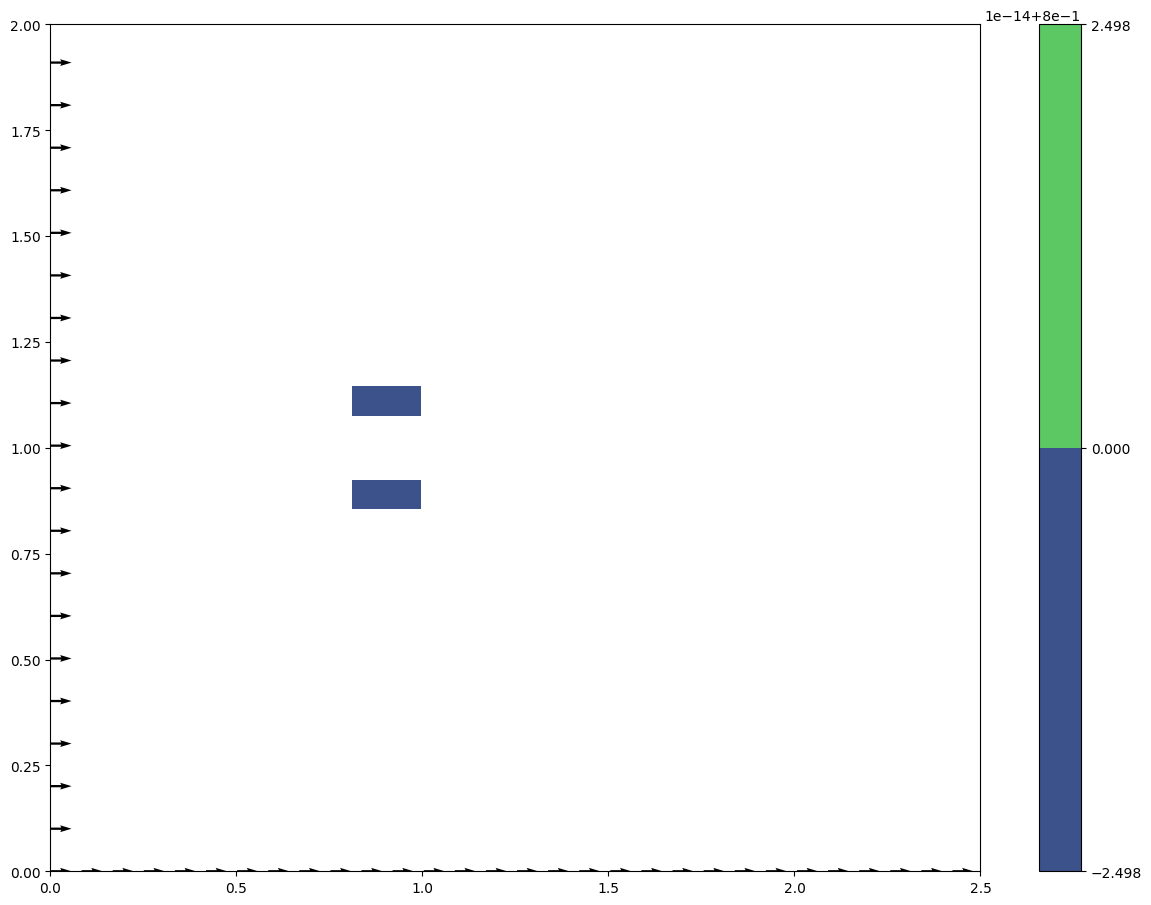

In [45]:
mgx = np.linspace(0, Lx, nx)
mgy = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(mgx, mgy)
fig = plt.figure(figsize=(15, 11))
a = np.percentile(p,5)
b = np.percentile(p,30)
c = np.median(p)
d = np.percentile(p,70)
e = np.percentile(p,90)
f = np.max(p)
levels = [a/2,a,b,c,d,e,f]
plt.contourf(X, Y, p.T)
plt.colorbar()
plt.quiver(X[::10,::10],Y[::10,::10],u.T[::10,::10],v.T[::10,::10])
plt.streamplot(X,Y,u.T,v.T,color='w')